In [1]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import json
from tqdm import tqdm
import torch.optim as optim
import yaml
import pickle
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

Carico il configuratore che tiene traccia di tutte le informazioni generali 

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
with open("./config.yaml", 'r') as f:
    config = yaml.safe_load(f)

# Download Dati

In questa parte carico i `.csv` e gli organizzo in modo tale che siano ordinati per

`(data, denominazione_regionale, denominazione_provincia)`

Inoltre pulisco i vari datase poiché ci sono una serie di righe che presentano delle problematicità in termini di valori.

La matrice di adiacenza generale è stata creata connettendo tutte le provincie di una determinata regione, in modo tale da mantenere una similitudine con il problema originario. Inoltre, per non distaccarsi troppo con la realtà, sono state inserite delle connessioni tra regioni dato che quest'ultime non sono isolate. In particolare sono state aggiunte connessioni tra tutti i capoluoghi.

In [25]:
df = pd.read_csv(os.path.join(config['paths']['data'],'codice_reg_prov.csv'), index_col=0)

In [26]:
df = df.sort_values(by = ["codice_regione", "codice_provincia"]).reset_index(drop= True)

In [38]:
df[df.codice_provincia.isin([22,44,55])]

,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia
22,4,Trentino,22,Trento
58,10,Umbria,55,Terni
62,11,Marche,44,Ascoli Piceno


In [33]:
ind = df[df.codice_regione.isin([2,5])].index.tolist()

In [34]:
ind

[8, 23, 24, 25, 26, 27, 28, 29]

In [19]:
def get_adj(config: yaml):
    if os.path.exists(os.path.join(config['paths']['adj'],"adj_totale.pkl")):
        with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "rb") as f:
            adj = pickle.load(f)
    else:
        codice_reg_prov = pd.read_csv(os.path.join(config['paths']['data'], "codice_reg_prov.csv"), index_col=0)

        # Carico un dizionario in cui le chiavi sono le regioni e i valori sono i rispettivi capoluohi
        with open(os.path.join(config['paths']['data'], "capoluoghi.json"), 'r') as f:
            capoluoghi = json.load(f)
        
        adjs = {}
        adj = np.zeros((len(codice_reg_prov), len(codice_reg_prov)))
        i = 0
        index_capoluoghi = []
        d = codice_reg_prov.groupby('denominazione_provincia').codice_provincia.max().to_dict()
        regioni = codice_reg_prov.groupby(by=['codice_regione']).codice_provincia.unique()
        
        for cod_reg in tqdm(regioni.index):
            codici_provincia = regioni[cod_reg]
            n_prov = len(codici_provincia)
            adjs[cod_reg] = np.ones((n_prov, n_prov))-np.eye(n_prov)
            adj[i:i+n_prov, i:i+n_prov] = adjs[cod_reg]

            region = codice_reg_prov[codice_reg_prov.codice_regione==cod_reg].denominazione_regione.values[0]
            codice_capoluogo = codice_reg_prov[codice_reg_prov.denominazione_provincia==capoluoghi[region]].codice_provincia.values[0]
            pos = np.where(codici_provincia == codice_capoluogo)[0][0]
            index_capoluoghi.append(i+pos)
            
            
            with open(os.path.join(config['paths']['adj'],f"adj_{region}.pkl"), "wb") as f:
                pickle.dump(adj, f)
                
            i += n_prov
        for ind_r in index_capoluoghi:
            for ind_c in index_capoluoghi:
                if ind_r != ind_c:
                    adj[ind_r, ind_c] = 1
                
        with open(os.path.join(config['paths']['adj'],"adj_totale.pkl"), "wb") as f:
            pickle.dump(adj, f)
        
    return adj


In [20]:
def fill_dataset(df: pd, 
                 config:yaml):
    # questa procedura serve solo ad inserire i dati sulle province mancanti
    d = []
    feat = df.shape[1]
    codici = list(df.codice_provincia.unique())
    codice_reg_prov = {tuple(x) for x in df[config['dataset']['col_categorical_prov']].values.tolist()}
    codice_reg_prov = pd.DataFrame(codice_reg_prov, columns=config['dataset']['col_categorical_prov'])
    j = 0
    for data in tqdm(df.data.unique(), desc = "filling"):
        tmp = df[df.data == data]
        if len(tmp) == len(codici):
            d.append(tmp)
        else:
            j+=1
            # individue le province mancanti
            codici_mancanti = [x for x in codici if x not in list(tmp.codice_provincia.unique())]
            code_regioni_mancanti = [codice_reg_prov[codice_reg_prov.codice_provincia == x].codice_regione.values[0] for x in codici_mancanti]
            tmp_mancante = pd.DataFrame(np.zeros((len(codici_mancanti),feat)), columns = df.columns)
            
            tmp_mancante.data = data
            tmp_mancante.codice_provincia = codici_mancanti
            tmp_mancante.codice_regione = code_regioni_mancanti
            tmp = pd.concat((tmp, tmp_mancante))
            if len(tmp) != len(codice_reg_prov):
                import pdb
                pdb.set_trace()
            d.append(tmp)
    df = pd.concat(d)

    bilancio = {}
    for csv in os.listdir('./data/'):
        if 'Bilancio demografico' in csv:
            tmp = pd.read_csv(f"./data/{csv}")
            tmp = tmp[tmp.Sesso == "Totale"][['Codice provincia', 'Popolazione al 1° gennaio']]
            tmp.rename(columns={'Codice provincia': 'codice_provincia', 
                                'Popolazione al 1° gennaio': 'popolazione'}, inplace=True)
            anno = int(csv.split(" ")[-1][:4])
            bilancio[anno] = tmp
    merge = []
    for anno in bilancio.keys():
        if anno != 2022:
            tmp = df[(df.data>pd.to_datetime(anno, format = '%Y'))&(df.data<pd.to_datetime(anno+1, format = '%Y'))]
        else:
            tmp = df[df.data>pd.to_datetime(anno, format = '%Y')]
        bi = bilancio[anno]
        bi = bi[bi.codice_provincia.isin(codice_reg_prov.codice_provincia.unique().tolist())]
        tmp = pd.merge(tmp, bi, on = 'codice_provincia', how ='left')
        merge.append(tmp)
    
    df = pd.concat(merge)    
    # Qua ordino le colonne come voglio altrimenti avrei variabile numeriche dove sono quelle categoriche
    df = df[config['dataset']['col_data'] + config['dataset']['col_numerical_prov']+ ['popolazione'] + config['dataset']['col_numerical_reg']+config['dataset']['col_categorical_prov']]
    df = df.drop(columns=["denominazione_regione", "denominazione_provincia"])
    df = df.sort_values(by = config['dataset']['ordering']).drop_duplicates(config['dataset']['ordering']).reset_index(drop = True)
    
    y = df[['data','codice_provincia', 'codice_regione', 'nuovi_casi']]    
    
    ## normalization for each region
    d = []
    col = config['dataset']['numerical']
    remaining = [x for x in list(df.columns) if (x not in col)&(x!='data')]
    for cod in df.codice_regione.unique():
        tmp = df[df.codice_regione==cod]        
        index = int(len(tmp)*0.8)
        for column in col:
            min = tmp[column].values[:index].min()
            max = tmp[column].values[:index].max()
            tmp[column] = (tmp[column]-min)/(max-min)            
        
        d.append(tmp)
        
    tmp = pd.concat(d,0)
    df = tmp.sort_values(by = config['dataset']['ordering']).reset_index(drop = True)  
    return df, y
    
def get_dataset(config: yaml):
    files = ["covid","target", "codice_reg_prov", "covid_province", "covid_regioni"]
    agg = "aggregate" if config['dataset']['aggregate'] else "not_aggregate"
    exists = [os.path.exists(os.path.join(config['paths']['data'],"aggregate", f"{file}.csv")) for file in files]
    
    if  np.all(exists):
        out = ()
        for file in files:
            tmp = pd.read_csv(os.path.join(config['paths']['data'], 'aggregate', f"{file}.csv"), index_col=0)
            if "data" in list(tmp.columns):
                tmp['data'] = pd.to_datetime(tmp['data'], format='%Y-%m-%d')
            out += (tmp,)
        return out[0], out[1]
        
    else:
        ########## I create take the dataset for the provinces
        if os.path.exists(os.path.join(config['paths']['data'],"aggregate/covid_province.csv")):
            provincials = pd.read_csv(os.path.join(config['paths']['data'],"covid_province.csv"))
            provincials['data'] = pd.to_datetime(provincials['data'], format='%Y-%m-%d')
        else:
            data = []
            for csv in tqdm(os.listdir(config['paths']['dati-province']), desc = "provincia"):
                if csv.split(".")[-1] == "csv":
                    data.append(pd.read_csv(os.path.join(config['paths']['dati-province'],csv)))
            
            
            data = pd.concat(data)
            data.reset_index(drop = True, inplace=True)
            data.data = data.data.apply(lambda x: x.split("T")[0])
            data.data = pd.to_datetime(data['data'], format='%Y-%m-%d')
            
            # Riduco il dataset con le variabili che servono
            # Inoltre trasformo la conta totale dei positivi per ogni regione in nuovi positivi
            data.rename(columns={'totale_casi': 'nuovi_casi'}, inplace=True)
            provincials = data[config['dataset']['col_data'] + config['dataset']['col_categorical_prov'] + config['dataset']['col_numerical_prov']]
            provincials = provincials.sort_values(by = config['dataset']['ordering'])
            provincials = provincials.drop_duplicates()
            provincials = provincials[-(provincials.codice_provincia>200)]
            provincials = provincials[-provincials.codice_regione.isin([21,22])].reset_index(drop = True)
            provincials.denominazione_regione = provincials.denominazione_regione.replace(['P.A. Bolzano', 'P.A. Trento'], "Trentino")
            
            tmp = provincials[['data','codice_provincia', 'nuovi_casi']]
            tmp = tmp.groupby('codice_provincia').diff().dropna().drop(columns = "data")
            # Non ha senso avere questi valori
            tmp = tmp[-tmp.nuovi_casi<0]
            
            #faccio un merge sugli indici
            provincials = pd.merge(provincials.drop(columns = "nuovi_casi"),tmp, left_index=True, right_index=True)
            provincials = provincials.reset_index(drop=True)
            provincials.to_csv(os.path.join(config['paths']['data'],"aggregate/covid_province.csv"))

                    
        if os.path.exists(os.path.join(config['paths']['data'], "aggregate/covid_regioni.csv")):
            regions = pd.read_csv(os.path.join(config['paths']['data'],"aggregate/covid_regioni.csv"))
            regions['data'] = pd.to_datetime(regions['data'], format='%Y-%m-%d')
        else:
            ########## I create take the dataset for the regions
            data = []
            for csv in tqdm(os.listdir(config['paths']['dati-regioni']), desc = "regione"):
                if csv.split(".")[-1] == "csv":
                    data.append(pd.read_csv(os.path.join(config['paths']['dati-regioni'],csv)))
            data = pd.concat(data).reset_index(drop = True)
            
            # Trento
            data.codice_regione = data.codice_regione.replace(21, 4)
            # Bolzano
            data.codice_regione = data.codice_regione.replace(22, 4)
            data.denominazione_regione = data.denominazione_regione.replace(['P.A. Bolzano', 'P.A. Trento'], "Trentino")
            
            data.data = data.data.apply(lambda x: x.split("T")[0])
            data.data = pd.to_datetime(data['data'], format='%Y-%m-%d')
            regions = data[config['dataset']['col_data'] + config['dataset']['col_categorical_reg'] + config['dataset']['col_numerical_reg']]
            regions = regions.drop_duplicates().reset_index(drop = True)
            regions.to_csv(os.path.join(config['paths']['data'],"aggregate/covid_regioni.csv"))
                    
        # Creo il dataset completo 
        if os.path.exists(os.path.join(config['paths']['data'],"aggregate/covid.csv")):
            df = pd.read_csv(os.path.join(config['paths']['data'], "aggregate/covid.csv"), index_col=0)
            df['data'] = pd.to_datetime(df['data'], format='%Y-%m-%d')
            y = pd.read_csv(os.path.join(config['paths']['data'], "aggregate/target.csv"), index_col=0)
            y['data'] = pd.to_datetime(y['data'], format='%Y-%m-%d')
        else:
            df = pd.merge(provincials, regions, 
                          how="left",  
                          on = config['dataset']['merge']) 
            df = df.sort_values(by = config['dataset']['ordering']).drop_duplicates(['data','codice_provincia']).reset_index(drop = True)
            df = df[config['dataset']['col_data'] + config['dataset']['col_numerical_prov']+config['dataset']['col_numerical_reg']+config['dataset']['col_categorical_prov']]

            codice_reg_prov = {tuple(x) for x in df[config['dataset']['col_categorical_prov']].values.tolist()}
            codice_reg_prov = pd.DataFrame(codice_reg_prov, columns=config['dataset']['col_categorical_prov'])
            df, y = fill_dataset(df, config)
            y.to_csv(os.path.join(config['paths']['data'],f"aggregate/target.csv"))
            if ~config['dataset']['aggregate']:
                for codice in df.codice_regione.unique():
                    tmp = df[df.codice_regione == codice].reset_index(drop = True)
                    tmp.to_csv(os.path.join(config['paths']['data'],f"not_aggregate/covid_{codice}.csv"))
                    y.to_csv(os.path.join(config['paths']['data'],f"not_aggregate/target_{codice}.csv"))
            codice_reg_prov.to_csv(os.path.join(config['paths']['data'],"aggregate/codice_reg_prov.csv"))
            df.to_csv(os.path.join(config['paths']['data'],"aggregate/covid.csv"))
            
    return df, y



In [21]:
df, y = get_dataset(config)
adj = get_adj(config)

In [6]:
class covid_dataset(Dataset):
    
    def __init__(self, 
                 df:pd,
                 y:pd,
                 adj: np.array,
                 past_step:int, 
                 future_step:int):
        """
        Arguments:
            df (pandas.Dataframe) : dataset to be processed.
            y (int) : target variable
            adj (np.array) : the static adiajency matrix 
            past_step (int): previous step to look back
            future_step (int): future step to look for
        """
        self.x = []
        self.y = []
        self.adj = []
        
        n = len(df.codice_regione.unique())
        date = np.sort(df.data.unique())
        n_provincie = len(df.codice_provincia.unique())
        start = 0
        dt = np.diff(date[:past_step+future_step]) == np.timedelta64(1, 'D')
        while any(not x for x in dt):
            start +=1
            dt = np.diff(date[start:past_step+future_step+ start]) == np.timedelta64(1, 'D')
               
        for i in tqdm(range(start, len(date)-future_step-past_step-1)):
            if date[i+past_step+future_step]-date[i+past_step+future_step-1] == np.timedelta64(1, 'D'): 
                tmp_x = df[df.data.isin(date[i:i+past_step])].drop(columns = "data").values
                tmp_y = y[df.data.isin(date[i+past_step:i+past_step+future_step])].nuovi_casi.values

                self.x.append(tmp_x.reshape(past_step, n_provincie, -1))
                self.y.append(tmp_y.reshape(future_step, -1))
                self.adj.append(np.tile(adj,(past_step,1,1)))
            else:
                i += past_step+future_step
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx], self.adj[idx]


In [7]:
past_step = config['setting']['past_step']
future_step = config['setting']['future_step']

if not os.path.exists(os.path.join(config['paths']['data'],f"aggregate/dataset{past_step}_{future_step}.pt")):
    
    dataset = covid_dataset(df,
                            y,
                            adj = adj, 
                            past_step=past_step, 
                            future_step=future_step)

100%|██████████████████████████████████████| 1214/1214 [00:07<00:00, 158.66it/s]


In [9]:
with open( os.path.join(config['paths']['data'],f"aggregate/dataset{past_step}_{future_step}.pkl"), 'wb') as f:
    pickle.dump(dataset, f)

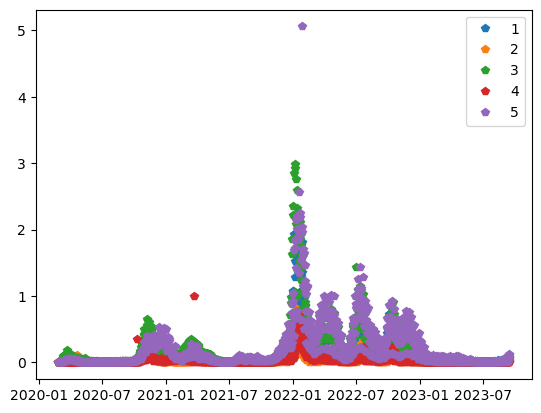

In [9]:
for codice in df.codice_regione.unique()[:5]:    
    plt.plot(df[df.codice_regione == codice].data.unique(), 
             df[df.codice_regione == codice].groupby('data').sum().nuovi_casi,'p', 
             label = codice)
plt.legend()
plt.show()